In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from run_temp import folder_temp, folder_gs
from analytical_results import fT00, fT01, fT11, fj0, fj1, fnu, fLn
from ploting import plot_heatmaps

save = False

In [2]:
g = 1
tol = 1e-6
#
ms = [0.5]
mg = [g * x for x in ms]
NaDdt = [ (64, 0.25, 512, 0.01), (128, 0.125, 512, 0.005),  (128, 0.0625, 512, 0.005),]



data = {}

for m in ms:
    for (N, a, D, dt) ,method in zip(NaDdt, ['2site',  '2site', '2site']):
        D0 = D
        try:
            folder = folder_temp(g, m, a, N, dt, D, tol, method)
            print(folder)
            data[m, N, a, D, dt] = np.load(folder / f"results.npy", allow_pickle=True).item()
        except FileNotFoundError:
            pass

print(*data.keys())

results_fermions/g=1.0000/m=0.5000/N=64/a=0.2500/temp/dt=0.0100/D=512/tol=1e-06/2site
results_fermions/g=1.0000/m=0.5000/N=128/a=0.1250/temp/dt=0.0050/D=512/tol=1e-06/2site
results_fermions/g=1.0000/m=0.5000/N=128/a=0.0625/temp/dt=0.0050/D=512/tol=1e-06/2site
(0.5, 64, 0.25, 512, 0.01) (0.5, 128, 0.125, 512, 0.005) (0.5, 128, 0.0625, 512, 0.005)


In [3]:
NUM_COLORS = 2
cm = plt.get_cmap('gist_rainbow')
colors = [cm(i / NUM_COLORS) for i in range(NUM_COLORS)]
lines = ['-', '--', ':']

In [4]:
def get_tsm(signals, ev):
    tm = signals["time"]
    mask = tm > -1
    tm = tm[mask]
    ee = signals[ev][mask]
    ee = ee - ee[-1, :]
    N = ee.shape[1]
    ee = (ee[:, 0::2] + ee[:, 1::2]) / 2  # average over 2*n and 2*n+1
    mid = (ee[:, N//4] +ee[:, N//4-1])/2
    return tm, ee, mid

Text(0.5, 0, 'T11')

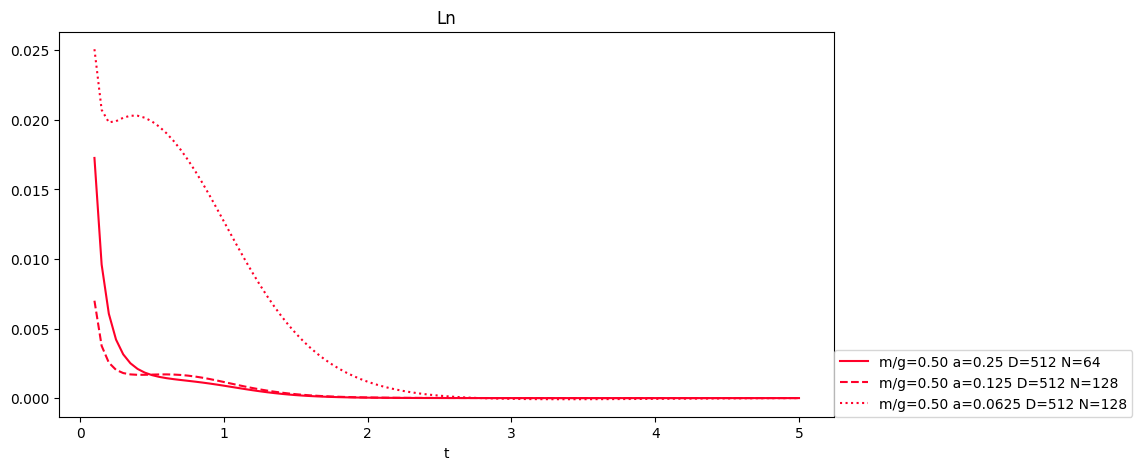

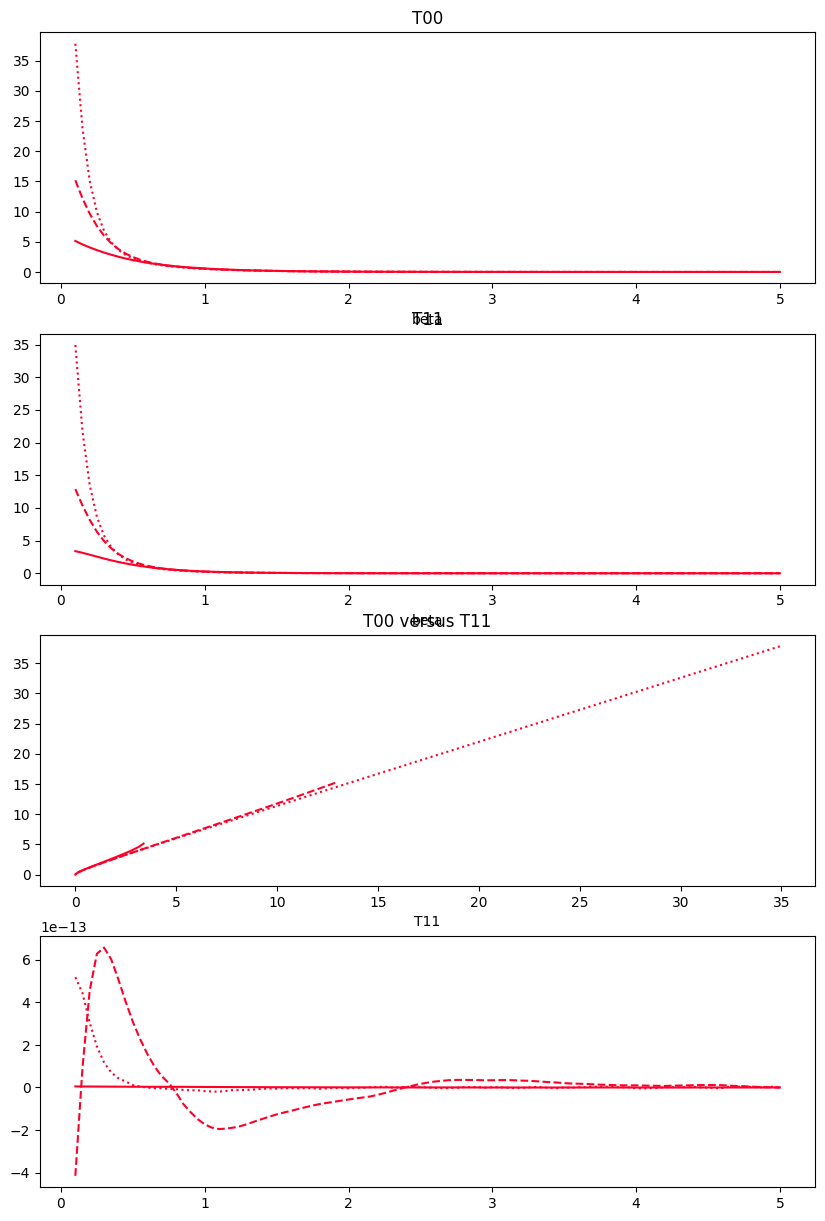

In [5]:
plt.figure(figsize=(10, 5))

for j, (N, a, D, dt) in enumerate(NaDdt):
    for i, m in enumerate(ms):
        try:
            tm, ee, mid = get_tsm(data[m, N, a, D, dt], 'Ln')
            line, = plt.plot(2*tm[2:], mid[2:], lines[j], color=colors[i])
            line.set_label(f'{m/g=:.2f} {a=} {D=} {N=}')
            np.savetxt(f'Ln_{m=:.2f}.txt', np.column_stack([tm[8:-1], mid[8:-1]]))
        except KeyError:
            pass

plt.legend(loc=(1,0))
plt.xlabel('t')
plt.title('Ln')

fig, ax = plt.subplots(4, 1, figsize=(10, 15))

for j, (N, a, D, dt) in enumerate(NaDdt):
    for i, m in enumerate(ms):
        try:
            tm, ee, midE = get_tsm(data[m, N, a, D, dt], 'T00')
            tm, ee, midp = get_tsm(data[m, N, a, D, dt], 'T11')
            tm, ee, mid01 = get_tsm(data[m, N, a, D, dt], 'T01')

            ax[0].plot(2*tm[2:], midE[2:], lines[j], color=colors[i], label=f'{m/g=:.2f} {a=} {D=} {N=}')
            ax[1].plot(2*tm[2:], midp[2:], lines[j], color=colors[i], label=f'{m/g=:.2f} {a=} {D=} {N=}')
            ax[3].plot(2*tm[2:], mid01[2:], lines[j], color=colors[i], label=f'{m/g=:.2f} {a=} {D=} {N=}')

            ax[2].plot(midp[2:], midE[2:], lines[j], color=colors[i], label=f'{m/g=:.2f} {a=} {D=} {N=}')
        except KeyError:
            pass

ax[0].set_title('T00')
ax[1].set_title('T11')
ax[2].set_title('T00 versus T11')

ax[0].set_xlabel('beta')
ax[1].set_xlabel('beta')
ax[2].set_xlabel('T11')

# ax[0].set_ylim([0, 0.5])
# ax[1].set_ylim([-0.5, 0.25])
# ax[2].set_xlim([-0.5, 0.25])
# ax[2].set_ylim([0, 0.5])

# ax[2].legend(loc=(1, 0))




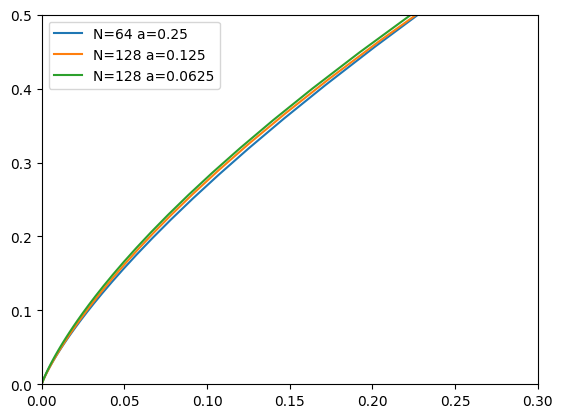

In [6]:
for j, (N, a, D, dt) in enumerate(NaDdt):
    for i, m in enumerate(ms):
        tm, ee, midE = get_tsm(data[m, N, a, D, dt], 'T00')
        tm, ee, midp = get_tsm(data[m, N, a, D, dt], 'T11')
        tm, ee, mid01 = get_tsm(data[m, N, a, D, dt], 'T01')
        plt.plot(midp[2:], midE[2:], label=f"{N=} {a=}")
plt.xlim([0, 0.3])
plt.ylim([0, 0.5])
plt.legend()

In [7]:
x = np.column_stack([midp[2:], midE[2:]])
np.savetxt("thermal_p_vs_e_m=0.5.txt", x)

In [8]:
# test energy from MPO vs T00
for i, m in enumerate(ms):
    for j, (N, a, D, dt) in enumerate(NaDdt):
        try:
            mask = data[m, N, a, D, dt]["time"] > -1  # when some points not calculated yet
            x1 = np.sum(data[m, N, a, D, dt]["T00"][mask, :], axis=1) * a
            x2 = data[m, N, a, D, dt]["energy"][mask]
            assert np.max(np.abs((np.abs(1 - x1 / x2) ))) < 1e-8
        except KeyError:
            pass


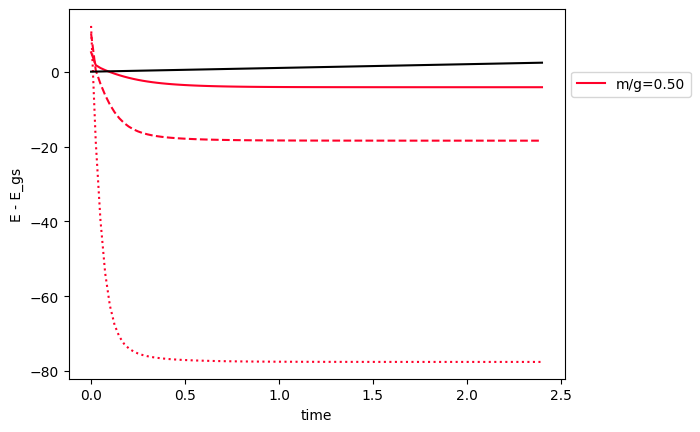

In [9]:
for i, m in enumerate(ms):
    for j, (N, a, D, dt) in enumerate(NaDdt):
        try:
            tm = data[m, N, a, D, dt]["time"]
            mask = tm > -1
            tm = tm[mask]
            en = data[m, N, a, D, dt]["T00"][mask][:, N // 2]
            line, = plt.plot(tm[:-4], en[:-4] , lines[j], color=colors[i],)
            if j == 0:
                line.set_label(f"{m/g=:0.2f}")
        except KeyError:
            pass


plt.plot(tm[:-4], tm[:-4], '-k')

plt.xlabel('time')
plt.ylabel('E - E_gs')
plt.legend(ncols=1, bbox_to_anchor=(1, 0.85))

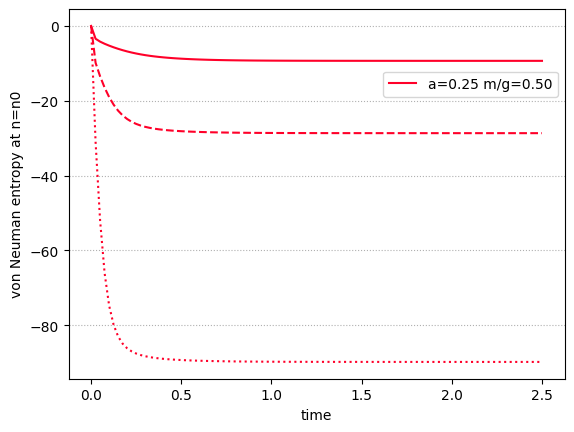

In [10]:
for j, (N, a, D, dt) in enumerate(NaDdt):
    for i, m in enumerate(ms):
        try:
            tm = data[m, N, a, D, dt]["time"]
            mask = tm > -1
            tm = tm[mask]
            ee = data[m, N, a, D, dt]["T00"][mask]
            ee = ee - ee[0]
            line, = plt.plot(tm, ee[:, N // 2] , lines[j], color=colors[i])
            if save:
                np.savetxt(f'S_x=0_{m=:.2f}.txt', np.column_stack([tm[8:-1], ee[8:-1, N // 2]]))
            if j == 0:
                line.set_label(f"{a=:0.2f} {m/g=:0.2f}")
        except KeyError:
            pass


plt.grid(axis="y", linestyle=':')

plt.xlabel('time')
plt.ylabel('von Neuman entropy at n=n0')
plt.legend(ncols=1, bbox_to_anchor=(1, 0.85))

von Neuman entropy between left and right parts of the lattice; We subtract values in the initial state.

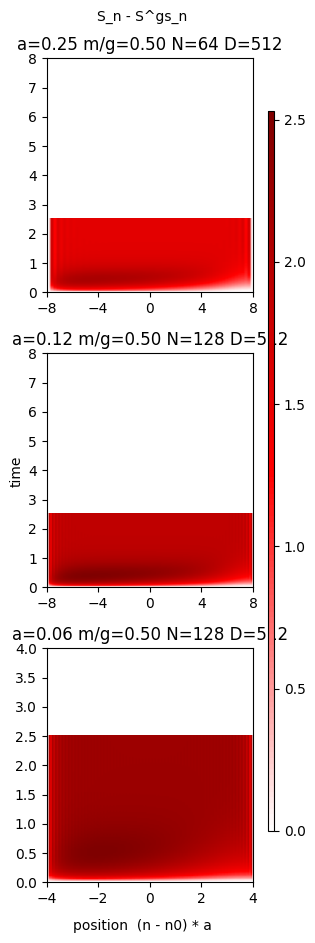

In [11]:
plot_heatmaps('entropy_1', 'S_n - S^gs_n', data, NaDdt, ms, g, subtract_t0=False, avarage_nn=False)

T00 - T00(t=0);  We might avarage over [2*l, 2*l+1] sites.


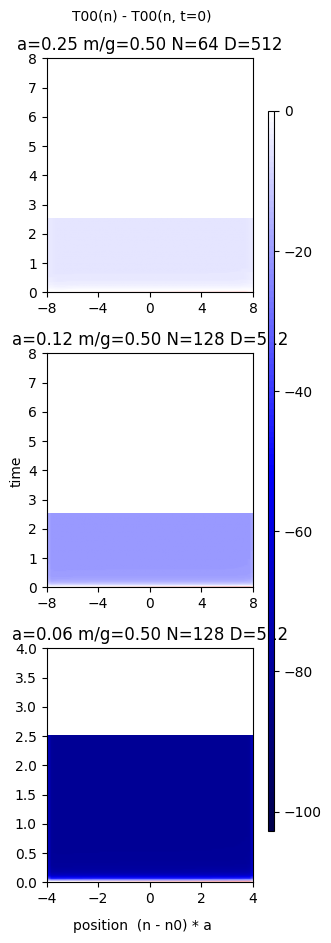

In [12]:
plot_heatmaps("T00", 'T00(n) - T00(n, t=0)', data, NaDdt, ms, g, None, subtract_t0=False, avarage_nn=True)  # None -> fT00,  for analytical m=0

T11; We avarage over [2*l, 2*l+1] sites, and subtract initial value.

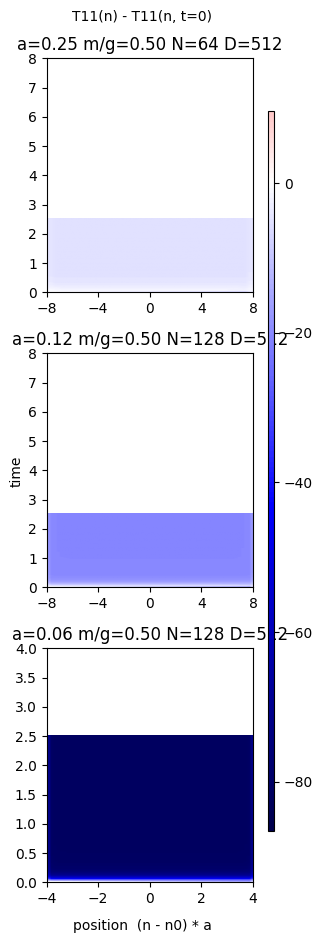

In [13]:
plot_heatmaps("T11", 'T11(n) - T11(n, t=0)', data, NaDdt, ms, g, None, subtract_t0=False, avarage_nn=True)  # None -> fT11,  for analytical m=0

T01 - T01(t=0); We can avarage over [2*l, 2*l+1] sites.

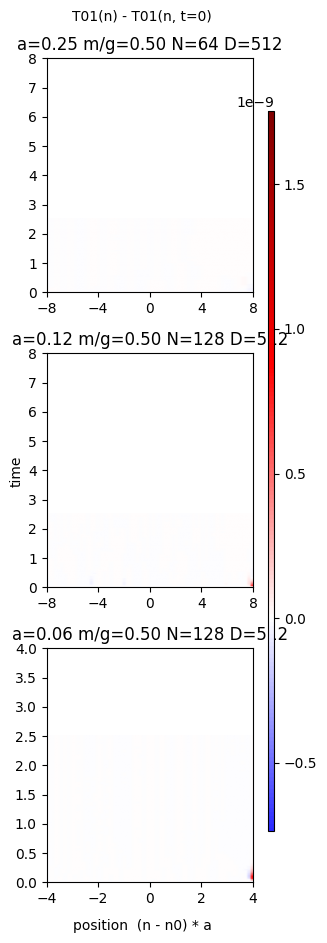

In [14]:
plot_heatmaps("T01", 'T01(n) - T01(n, t=0)', data, NaDdt, ms, g, None, subtract_t0=False, avarage_nn=True)  # fT01,

j0; subtract j0(t=0)

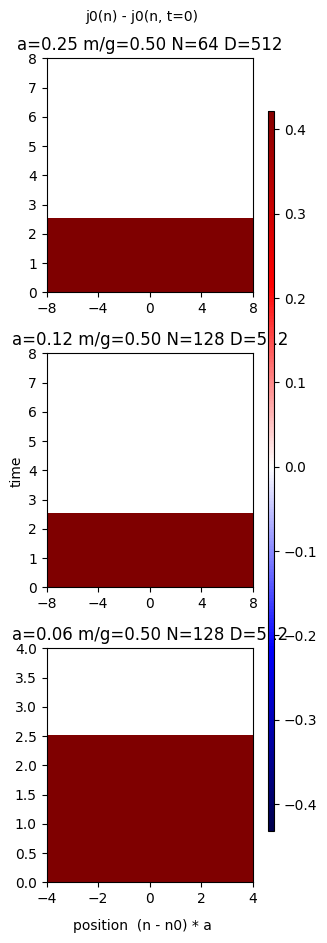

In [15]:
plot_heatmaps("j0", 'j0(n) - j0(n, t=0)', data, NaDdt, ms, g, None, subtract_t0=False, avarage_nn=False)  # fj0,

j1;

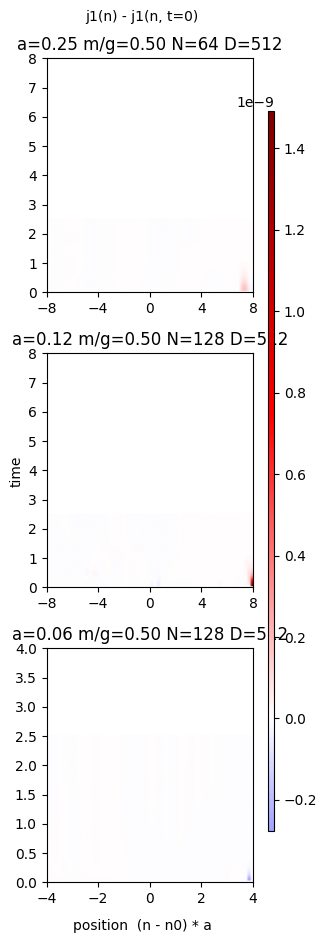

In [16]:
plot_heatmaps("j1", 'j1(n) - j1(n, t=0)', data, NaDdt, ms, g, None, subtract_t0=False, avarage_nn=False)  # fj1,

condensate

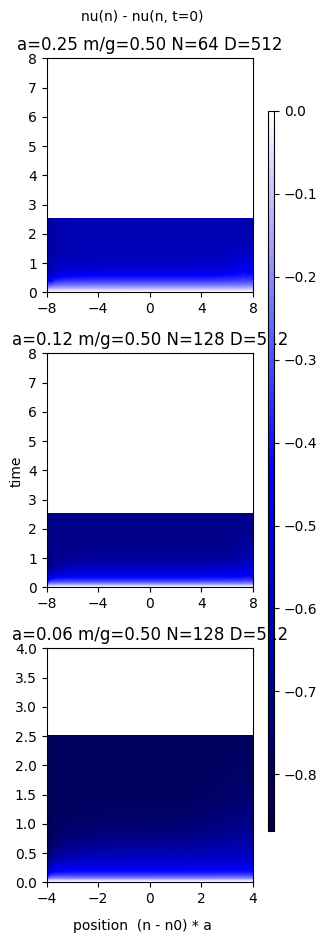

In [17]:
plot_heatmaps("nu", 'nu(n) - nu(n, t=0)', data, NaDdt, ms, g, None, subtract_t0=False, avarage_nn=False)  #  fnu,

Ln

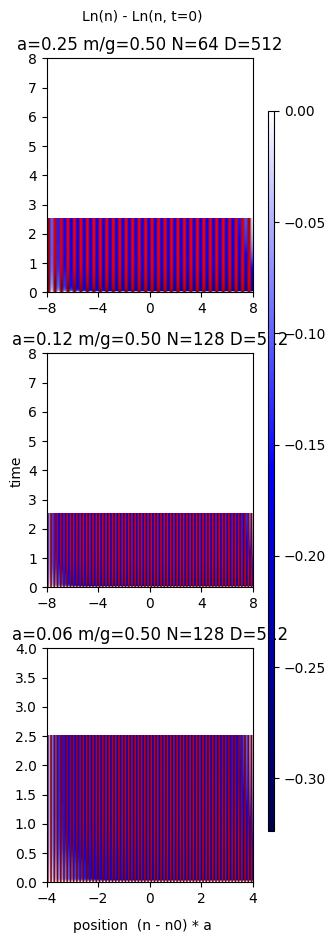

In [18]:
plot_heatmaps("Ln", 'Ln(n) - Ln(n, t=0)', data, NaDdt, ms, g, None, subtract_t0=False, avarage_nn=False)  # fLn,